In [3]:
from typing import Tuple, List, Optional
from dataclasses import dataclass
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Here are the dynamics and the observation models:

$$ SOC(k+1) = SOC(k) - \frac{dt}{Qnom}I(k) $$

$$V_CT(k+1) = e^{\frac{dt}{\tau_CT}}V_{CT}(k) + R_{CT}(1- e^)

In [4]:
# Define some data structures for better code syntax.
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [5]:
# Define the state-space model for the battery

def battery_model_jacobian(state, current, params):

    SoC, V_CT, V_dif = state
    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    return np.array([[-1., 0., 0.], [0., np.exp(-dt/tau_CT), 0.], [0., 0., np.exp(-dt/tau_dif)]])

#def battery_model(state, current, params):

#    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0 = params

#    A = np.array([
#        [1, 0, 0],
#        [0, np.exp(-dt / tau_CT), 0],
#        [0, 0, np.exp(-dt / tau_dif)]
#    ])

#    B = np.array([
#        -dt / Q_nom,
#        R_CT * (1 - np.exp(-dt / tau_CT)),
#        R_dif * (1 - np.exp(-dt / tau_dif))
#    ])

#    next_state = np.dot(A, state) + B*current #A @ state.T@ A.T + B@current

#    return next_state

def coulomb_counting(initial_SoC, Nsims, params):

    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params
    SoC_record = np.zeros((Nsims, 1))
    SoC_record[0] = initial_SoC
    for kk in range(1, Nsims):
        time = kk*dt
        current = current_user(time)
        SoC_record[kk] = SoC_record[kk-1] - (dt / Q_nom) * current
    
    return SoC_record

def battery_model(state, current, params):

    SoC, V_CT, V_dif = state
    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    SoC_next = SoC - (dt / Q_nom) * current
    V_CT_next = np.exp(-dt / tau_CT) * V_CT + R_CT * (1 - np.exp(-dt / tau_CT)) * current
    V_dif_next = np.exp(-dt / tau_dif) * V_dif + R_dif * (1 - np.exp(-dt / tau_dif)) * current

    return np.array([SoC_next, V_CT_next, V_dif_next])

def V_OCV(SoC, dt, Nsims):

    data = pd.read_csv('VOCV_SOC_map.csv')
    SoC_arr = np.array(data['time'])
    V_arr = np.array(data[' V'])

    tfinal = Nsims*dt

    # create a unifrom time vector
    time_uniform = np.arange(0, tfinal, dt)

    # interpolate voltage
    v_interpolated = np.interp(time_uniform, SoC_arr, V_arr)

    closest_index = (np.abs(time_uniform - SoC)).argmin()

    return v_interpolated[closest_index]

def current_user2(time):
    if time%2>0 and time%2<0.2:
        return 25
    elif time%2>0.2 and time%2<1:
        return 18
    elif time%2>1 and time%2<1.8:
        return 8
    elif time%2>1.8 and time%2<2:
        return 0
    else:
        return 0

def current_user(t, params):

    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    time = t*dt
    if time%2>0 and time%2<0.2:
        return 25
    elif time%2>0.2 and time%2<1:
        return 18
    elif time%2>1 and time<1.8:
        return 8
    elif time%2>1.8 and time%2<2:
        return 0
    else:
        return 0

def battery_observation_model(state, current, params):

    SoC, V_CT, V_dif = state
    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    VOCV = V_OCV(SoC, dt, Nsims)
    V = VOCV - V_CT - V_dif - R0*current

    return V

def battery_observation_model_Jacobian(state, current, params):

    # for now assume that V_OCV(SoC) is a straight line joining
    ## (0, 3.2) and (1, 4.2)
    ## V_OCV = SoC + 3.2 - hence delVOCV/delSoC = 1

    return np.array([[1., -1., -1.]])
    #return np.array([[1.0, 0.0, 0.0]])

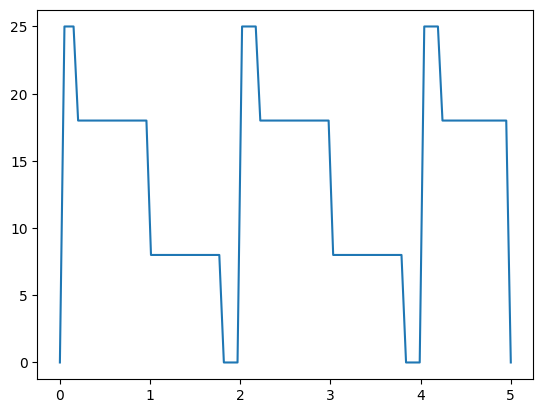

In [6]:
t = np.linspace(0, 5, 100)
current = [current_user2(i) for i in t]

plt.plot(t, current)

In [7]:
# Define prediction step and update step for the Extended Kalman Filter

def EKF_prediction_step(X: Gaussian, xi: Gaussian, params: np.ndarray, timestep: np.int32) -> Gaussian:
    """Linear Prediction Step: Propagate uncertainty for one time step.

    X_{k+1} = g(X_{k}) + xi, xi sim mathcal{N}{noise_mean, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    X: Gaussian := state variable
    xi: Gaussian := noise variable
    params: numpy array of R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0

    Intermediates:
    pred_mean := bar{mu} := predicted mean of the state
    pred_cov := bar{Sigma}j := predicted covariance of the state

    Returns
    -------
    A Gaussian random variable for the next time step
    J := predicted covariance of the state
    pred_cov := bar{Sigma} := predicted covariance of the state

    Returns
    -------
    A Gaussian random variable for the next time step
    """
    
    i = current_user(timestep, params)
    pred_mean = battery_model(X.mean, i, params) + xi.mean
    J = battery_model_jacobian(X.mean, i, params)
    pred_cov = J @ X.cov @ J.T + xi.cov
    return Gaussian(pred_mean, pred_cov)

In [8]:
def EKF_update_step(data: np.ndarray, X: Gaussian, eta: Gaussian, params: np.ndarray, timestep: np.int32) -> Gaussian:
    """Linear Gaussian Inverse Problem.

    Inputs
    ------
    data: (N) array of data
    X: Gaussian := state variable
    eta: Gaussian := noise variable

    Intermediates:
    H := measurement/observation model Jacobian
    X := State distrubution
    eta := noise distribution

    Returns
    -------
    Gaussian Posterior
    """

    """i = current_user(timestep, params)
    H = battery_observation_model_Jacobian(X.mean, i, params)
    U = np.dot(X.cov, H.T)
    S = np.dot(H, U) + eta.cov
    mu = np.dot(H, X.mean) + eta.mean

    # Kalman Gain
    K = np.linalg.solve(S, H@X.cov).T
    update_mean = X.mean + K@np.atleast_1d(data - mu)
    update_cov = X.cov - K@S@K.T
    """

    i = current_user(timestep, params)
    C = battery_observation_model_Jacobian(X.mean, i, params)
    P = X.cov
    R = eta.cov
    S = np.linalg.inv(C @ P @ C.T + R)
    L = P @ C.T @ S
    mu = battery_observation_model(X.mean, i, params)
    update_mean = X.mean + L@np.atleast_1d(data - mu)
    update_cov = P - L @ C @ P

    #update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    #update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)

In [9]:
# Define the main loop for the Extended Kalman Filter

def extended_kalman_filter(data: Observations,
                  X: Gaussian,
                  xi: Gaussian,
                  eta: Gaussian, 
                  params: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    X: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    EKFTracker
    """

    num_steps = data.times.shape[0]
    d = X.mean.shape[0]


    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(X.mean)

    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(X.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    # Loop over all time steps
    Xnext = X
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = EKF_prediction_step(Xnext, xi, params, ii)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = EKF_update_step(y, Xpred, eta, params, ii)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, : ,:] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

In [10]:
# Write a function to generate truth as well as simulated observed data.

def generate_data(times: np.ndarray,
                  N: int,
                  dt: np.float32,
                  obs_freq: int,
                  x0: np.ndarray,
                  O: np.ndarray,
                  obs_names: List[str],
                  mm: np.ndarray,
                  Q: np.ndarray,
                  om: np.float32,
                  R: np.float32, 
                  params: np.ndarray) -> Tuple[Observations, Observations]:

    """Generate the truth and data for the second-order system

    times:= time instances for simulation
    N:= number of time steps
    dt:= time step
    obs_freq:+ frequency to capture model observations
    x0:= initial state
    obs_names:= names of the observations
    O:= observation matrix, describes which states are to be observed
    mm: motion model noise mean
    Q: motion model noise covariance matrix
    om: measurement model noise mean
    R: measurement model noise covariance matrix

    """
    xout = np.zeros((N, 3)) # output states
    xout[0, :] = x0         # populate output with initial state

    obs_ind = np.arange(obs_freq, N, obs_freq) # indices where observations have to be performed
    num_obs =  obs_ind.shape[0] # number of observations
    on_obs = 0 # number of observations recorded
    yout = np.zeros((num_obs, O.shape[0]))

    for ii in range(1, N):
        current = current_user(ii, params)
        xout[ii, :] = battery_model(xout[ii-1, :], current, params) # populate dynamics update
        if on_obs < num_obs and ii == obs_ind[on_obs]:
            # populate observsation update
            #print(f"The shape of np.dot operation is : {np.dot(O, xout[ii, :]).shape}")
            #yout[on_obs, :] = np.dot(O, xout[ii, :]) + np.random.normal(om, np.sqrt(R))
            #yout[on_obs, :] = O*xout[ii, :] + np.random.normal(om, np.sqrt(R))
            yout[on_obs, :] = battery_observation_model(xout[ii, :], current, params) + np.random.normal(om, np.sqrt(R))
            on_obs += 1

    trueData = Observations(times, np.arange(N), xout, ['SoC', 'V_CT', 'V_dif'])
    obsData = Observations(times, obs_ind, yout, obs_names)
    return trueData, obsData

In [11]:
# unchanging simulation parameters
dt, Nsims_ekf, n_states = 1e-2, 600, 3

# battery model parameters
R_CT, tau_CT, R_dif, tau_dif, Q_nom, R0 = 1.6*10**-3, 3.68, 7.7*10**-3, 84.34, 10.4, 6*10**-3
params_ekf = [R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims_ekf]

# the R0 should vary with respect to time, but for now we can just keep it constant with respect to time

Tf_ekf = Nsims_ekf * dt                         # final time for simulation
x0_ekf = np.array([1.50, 2, 0])                 # initial values of states
time_ekf = np.linspace(0, Tf_ekf, Nsims_ekf)    # time array for ekf 
obs_names_ekf = ['observations: V']             # names of observations
X_ekf = Gaussian(x0_ekf, np.eye(n_states))      # prior
O_ekf = np.array([[0., 1, 1]])                  # observation matrix
mm_ekf = np.zeros(n_states)                     # process model noise mean
om_ekf = 0.0                                    # observation model noise mean
covval = 8.432 * 10**-4                         # observation model noise covariance
Q_ekf = np.array([[1000*covval, 0.0, 0.0], 
                  [0.0, 10*covval, 0.0], 
                  [0.0, 0.0, 1*covval]])        # process model noie covariance


# for overlay analysis
deltas_ekf = np.array([3, 5])
Rs_ekf = np.array([1, 0.01])

colors = ['blue', 'green', 'red']

Text(0.5, 1.0, 'Delta: 10, R: 0.0008432000000000001 and RMSE error: 0.996')

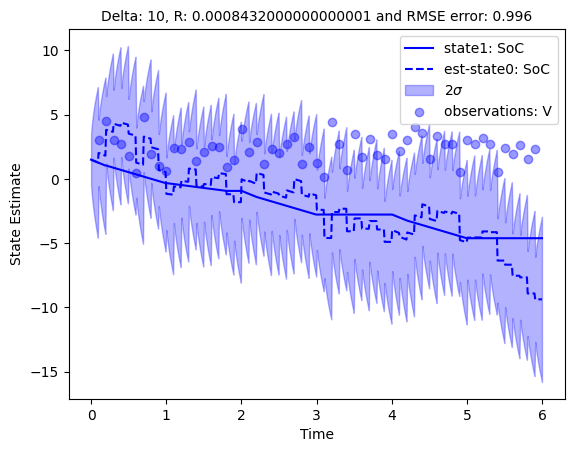

In [12]:
truth, noisy_obs = generate_data(time_ekf, Nsims_ekf, dt, 10, x0_ekf, O_ekf, obs_names_ekf, mm_ekf, Q_ekf, om_ekf, 1, params_ekf)
process_noise = Gaussian(mm_ekf, Q_ekf)
meas_noise = Gaussian(om_ekf, covval)
kf_res = extended_kalman_filter(noisy_obs, X_ekf, process_noise, meas_noise, params_ekf)

# compute RMSE
RMSE = np.sqrt(np.mean((kf_res.means - truth.obs)**2))

plt.plot(truth.times, truth.obs[:, 0], color=colors[0], label='state1: SoC')
#plt.plot(truth.times, truth.obs[:, 1], color=colors[1], label='state2: V_CT')
#plt.plot(truth.times, truth.obs[:, 2], color=colors[2], label='state3: V_dif')


plt.plot(noisy_obs.times, kf_res.means[:, 0], '--', color=colors[0], label='est-state0: SoC')
#plt.plot(noisy_obs.times, kf_res.means[:, 1], '--', color=colors[1], label='est-state1: V_CT')
#plt.plot(noisy_obs.times, kf_res.means[:, 2], '--', color=colors[2], label='est-state2: V_dif')
      
plt.fill_between(noisy_obs.times,
                         kf_res.means[:, 0] - 2 * kf_res.stds[:, 0],
                         kf_res.means[:, 0] + 2 * kf_res.stds[:, 0],
                         color=colors[0], alpha=0.3, label=r'2$\sigma$')
#plt.fill_between(noisy_obs.times,
#                         kf_res.means[:, 1] - 2 * kf_res.stds[:, 1],
#                         kf_res.means[:, 1] + 2 * kf_res.stds[:, 1],
#                         color=colors[1], alpha=0.3)
#plt.fill_between(noisy_obs.times, 
#                             kf_res.means[:, 2] - 2*kf_res.stds[:, 2], 
#                             kf_res.means[:, 2] + 2*kf_res.stds[:, 2],
#                             color = colors[2], alpha=0.3)

plt.xlabel('Time', fontsize=10)
plt.ylabel('State Estimate',fontsize=10)
plt.scatter(noisy_obs.times[noisy_obs.obs_ind], noisy_obs.obs,
                           color=colors[0], alpha=0.4, label=noisy_obs.names[0])
plt.legend()
plt.title(f'Delta: {10}, R: {covval} and RMSE error: {np.round(RMSE, 3)}', fontsize=10)
#plt.set_title(f'Delta: {deltas[i]}, R: {Rs[j]} and RMSE error: {np.round(RMSE, 3)}', fontsize=10)

In [13]:
def plot_grid(rows, cols, figsize, deltas, Rs, time, Nsims, dt, x0, O, obs_names, mm, Q, om, X, params):
  fig, axs = plt.subplots(rows, cols, figsize=figsize)
  kf_results = []
  for i in range(len(deltas)):
    for j in range(len(Rs)):
      truth, noisy_obs = generate_data(time, Nsims, dt, deltas[i], x0, O, obs_names, mm, Q, om, Rs[j], params)
      process_noise = Gaussian(mm, np.sqrt(Q))
      meas_noise = Gaussian(om, np.sqrt(Rs[j]))
      kf_res = extended_kalman_filter(noisy_obs, X, process_noise, meas_noise, params)
      kf_results.append(kf_res)

      # compute RMSE
      RMSE = np.sqrt(np.mean((kf_res.means - truth.obs)**2))

      axs[i, j].plot(truth.times, truth.obs[:, 0], color=colors[0], label='state1: SoC (Coulomb Counting)')
      #axs[i, j].plot(truth.times, truth.obs[:, 1], color=colors[1], label='state2: V_CT')
      #axs[i, j].plot(truth.times, truth.obs[:, 2], color=colors[2], label='state3: V_dif')


      axs[i, j].plot(noisy_obs.times, kf_res.means[:, 0], '--', color=colors[0], label='est-state0: SoC')
      #axs[i, j].plot(noisy_obs.times, kf_res.means[:, 1], '--', color=colors[1], label='est-state1: V_CT')
      #axs[i, j].plot(noisy_obs.times, kf_res.means[:, 2], '--', color=colors[2], label='est-state2: V_dif')
      
      axs[i, j].fill_between(noisy_obs.times,
                         kf_res.means[:, 0] - 2 * kf_res.stds[:, 0],
                         kf_res.means[:, 0] + 2 * kf_res.stds[:, 0],
                         color='green', alpha=0.3)
      #axs[i, j].fill_between(noisy_obs.times,
      #                   kf_res.means[:, 1] - 2 * kf_res.stds[:, 1],
      #                   kf_res.means[:, 1] + 2 * kf_res.stds[:, 1],
      #                   color=colors[1], alpha=0.3)
      #axs[i, j].fill_between(noisy_obs.times, 
      #                       kf_res.means[:, 2] - 2*kf_res.stds[:, 2], 
      #                       kf_res.means[:, 2] + 2*kf_res.stds[:, 2],
      #                       color = colors[2], alpha=0.3)

      axs[i, j].set_xlabel('Time', fontsize=20)
      axs[i, j].set_ylabel('State Estimate',fontsize=20)
      axs[i, j].set_title(f'Delta: {deltas[i]}, R: {Rs[j]} and RMSE error: {np.round(RMSE, 3)}', fontsize=20)


      # for ii in range(noisy_obs.obs.shape[1]):
      #   axs[i, j].scatter(noisy_obs.times[noisy_obs.obs_ind], noisy_obs.obs,
      #                      color='green', alpha=0.4, label=noisy_obs.names[0])

      axs[i, j].legend(fontsize=20)

  plt.savefig('ekf.png', dpi=300, bbox_inches='tight')
  plt.show()

  return kf_results

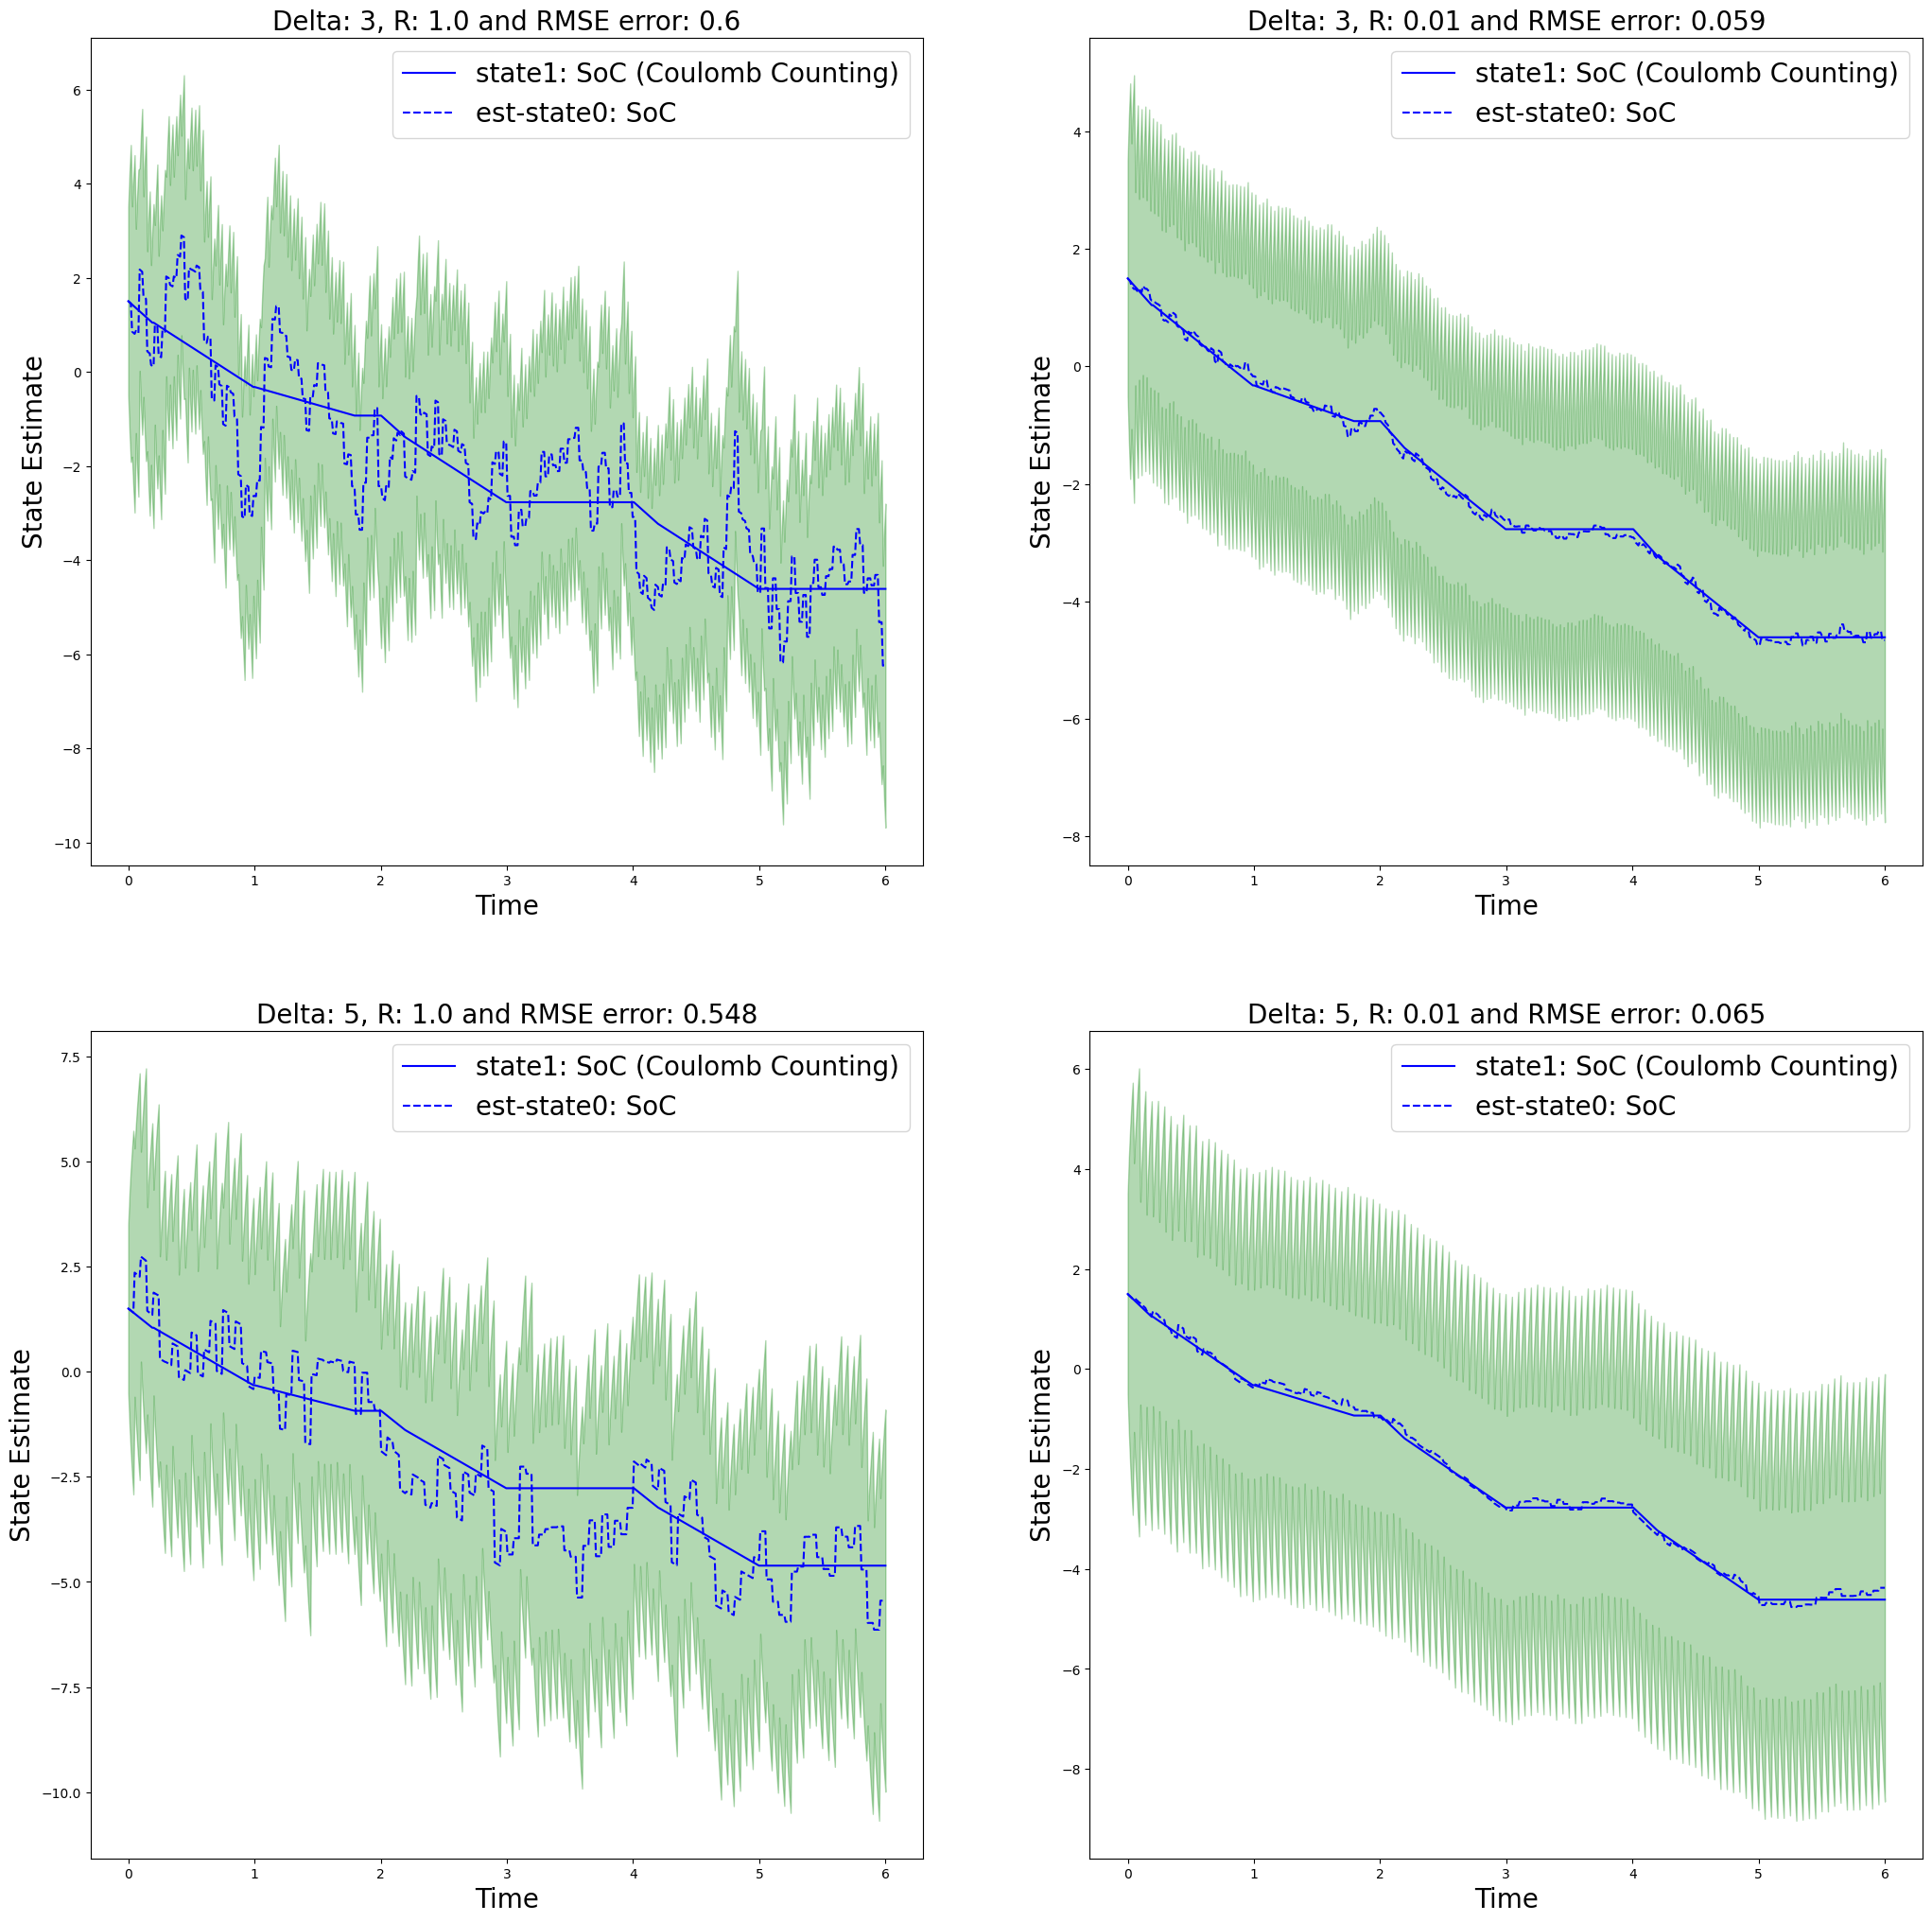

In [14]:
kf_results = plot_grid(len(deltas_ekf), len(Rs_ekf), (25, 25), deltas_ekf, Rs_ekf, time_ekf, Nsims_ekf, dt, x0_ekf, O_ekf, obs_names_ekf, mm_ekf, Q_ekf, om_ekf, X_ekf, params_ekf)